In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

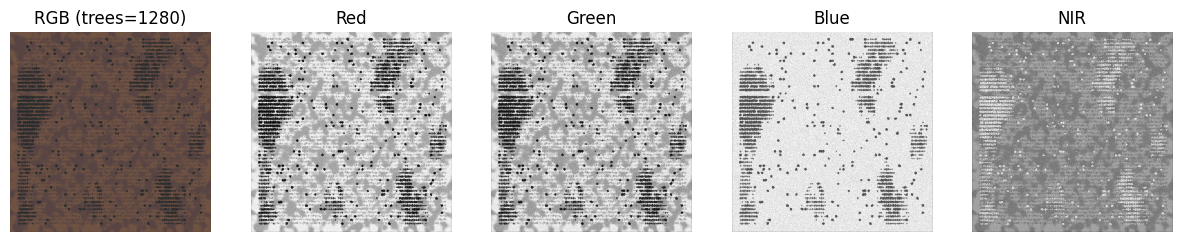

In [ ]:
index = 0
dir = "outputs"
norm_factor = 1600

output = np.load(os.path.join(dir, "output.npy"))
count = np.load(os.path.join(dir, "count.npy"))

image = (output[index]/1600).transpose(1, 2, 0)

fig, axs = plt.subplots(1, 5, figsize=(15, 10))
axs[0].imshow(image[:,:,:3])
axs[1].imshow(image[:,:,0], cmap="gray")
axs[2].imshow(image[:,:,1], cmap="gray")
axs[3].imshow(image[:,:,2], cmap="gray")
axs[4].imshow(image[:,:,3], cmap="gray")

axs[0].set_title(f"RGB (trees={count[index].item()})")
axs[1].set_title("Red")
axs[2].set_title("Green")
axs[3].set_title("Blue")
axs[4].set_title("NIR")

for i in range(5):
    axs[i].axis("off")

fig.show()

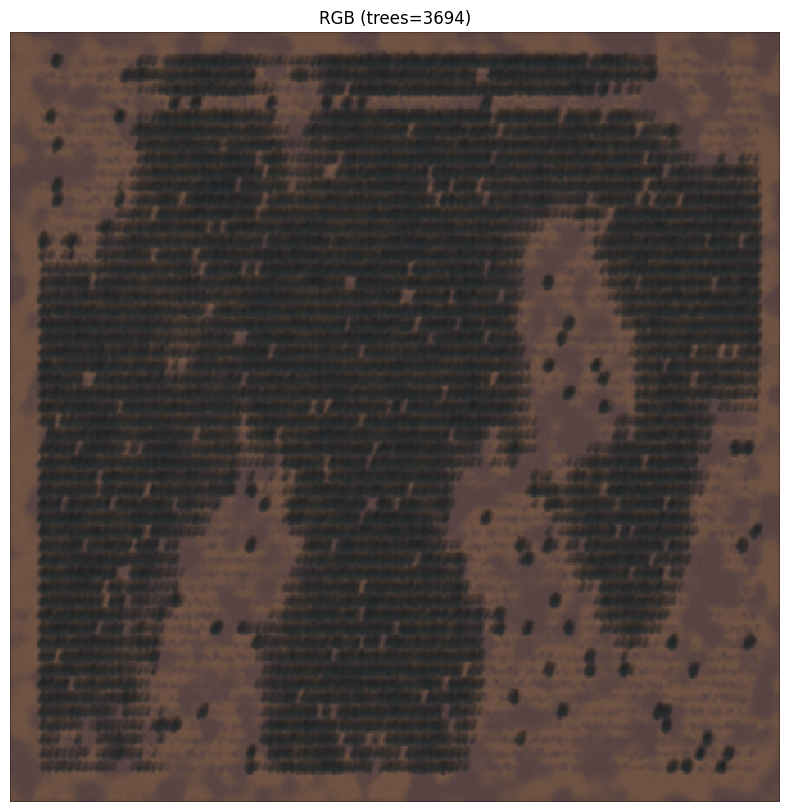

In [75]:
index = 0
dir = "outputs"
norm_factor = 1600

output = np.load(os.path.join(dir, "output.npy"))
coordinates = np.load(os.path.join(dir, "coordinates.npz"))
count = np.load(os.path.join(dir, "count.npy"))


image = (output[index]/1600).transpose(1, 2, 0)
coords = coordinates[f"coords{index}"]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(image[:,:,:3])
# ax.scatter(coords[:, 0], coords[:, 1], marker='.', c="red", s=10, alpha=0.5)

ax.set_title(f"RGB (trees={count[index].item()})")

ax.axis("off")

fig.show()